# Importation des modules

In [393]:
# Pour manipuler et visualiser les données
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pour séparer et évaluer les données
from sklearn.model_selection import train_test_split, cross_validate, KFold, learning_curve, GridSearchCV, RandomizedSearchCV

# Pour préparer les données
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

# Pour créer des arbres de classification
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

# Pour faire un modèle de régression logistique 
from sklearn.linear_model import LogisticRegression

# Pour utiliser xgboost
import xgboost as xgb

# Pour utiliser les métriques
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

# Pour exporter notre modèle
import pickle

# pour utiliser PCA et MLflow
from sklearn.decomposition import PCA
import mlflow
import mlflow.sklearn

# Création du dataset et Dummy Classifier

On commence par créer un dataset avec les variables :
<p style='color: #FFA07A'> NAICS, NoEmp, RetainedJob, UrbanRural, Term, UrbanRural, MIS_Status </p>

In [394]:
df = pd.read_csv("archive/SBAnational_clean.csv")

/tmp/ipykernel_31367/3668100114.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("archive/SBAnational_clean.csv")


In [395]:
df['NAICS'] = df['NAICS'].astype(str).apply(lambda x : x[:2])
df[['NAICS']] = df[['NAICS']].astype(int)

In [396]:
df["NAICS"].unique()

array([45, 72, 62,  0, 33, 81, 23, 44, 42, 61, 53, 54, 31, 51, 71, 52, 21,
       32, 56, 48, 11, 92, 22, 49, 55])

In [397]:
# Dataframe contenant les variables explicatives
X = df[['NAICS', 'NoEmp',  'RetainedJob', 'UrbanRural','Term']]

# On transforme les valeurs de MIS_Status en 0 ou 1
y = df['MIS_Status'].astype('category').cat.codes

In [398]:
y.value_counts()

1    729148
0    155977
dtype: int64

On crée maintenant notre jeu de données d'entraînement et de test :

In [399]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=42, stratify=y)

On sépare les variables numériques et catégorielle :

In [400]:
var_num = ['NoEmp','RetainedJob','Term','NAICS']

var_cat = [ 'UrbanRural']

Puis on crée un transformateur de colonne :

In [401]:
preprocessor = make_column_transformer(
    (StandardScaler(), var_num),
    (OneHotEncoder(), var_cat)
)

On commence notre modélisation par un Dummy Classifier qui servira de point de comparaison :

In [402]:
dummy = make_pipeline(preprocessor, DummyClassifier())

dummy.fit(X_train, y_train)

y_pred = dummy.predict(X_test)

dummy_report = (classification_report(y_test, y_pred))
print(dummy_report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     31195
           1       0.82      1.00      0.90    145830

    accuracy                           0.82    177025
   macro avg       0.41      0.50      0.45    177025
weighted avg       0.68      0.82      0.74    177025



/home/apprenant/Documents/Projet_Classification/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/apprenant/Documents/Projet_Classification/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/apprenant/Documents/Projet_Classification/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

# Random Forest Classifier

Nous allons maintenant utiliser un Random Forest Classififier sans paramètres pour le comparer avec notre Dummy Classifier :

In [403]:
# # Entraînement du modèle
# rf_pipe = make_pipeline(preprocessor, RandomForestClassifier())
# rf_pipe.fit(X_train, y_train)

On affiche l'importance des features :

In [404]:
# importances = rf_pipe[-1].feature_importances_
# importances
# # features = pd.DataFrame({"feature": X_train.columns, "importance": importances})
# # features

In [405]:
# rf_pipe.get_feature_names_out

In [406]:
# y_pred = rf_pipe.predict(X_test)

# rfc_report = classification_report(y_test, y_pred)
# print(rfc_report)

En utilisant un Random Forest Classifier sans paramètres, on obtient de bons résultats, proches de notre Dummy Classifier pour les classes positives. <br>
On va essayer d'affiner notre modèle avec en cherchant les meilleurs hyperparamètres :

In [407]:
# # On définit les paramètres à rechercher avec un intervalle de recherche
# param_dist = {'n_estimators': np.arange(30, 100, 1), 
#               'max_depth': np.arange(1, 11),
#               'min_samples_split': np.arange(2, 10),
#               'min_samples_leaf': np.arange(1, 10),
#               'criterion': ['gini','entropy']}

# # On crée un objet Random Search 
# random_search = RandomizedSearchCV(rf_pipe[-1], param_distributions=param_dist,
#                                   cv=5, n_jobs=-1, verbose=1)

# # On entrâine le modèle
# random_search.fit(X_train, y_train)

# # On récupère les meilleurs hyperparamètres trouvés
# best_params = random_search.best_params_
# print(best_params)

# # Entraînement du modèle
# rf_pipe = make_pipeline(preprocessor, RandomForestClassifier(**best_params, class_weight="balanced"))
# rf_pipe.fit(X_train, y_train)

# y_pred = rf_pipe.predict(X_test)

# print(f"resultats après grid search :\n {classification_report(y_test, y_pred)}")
# print(f"resultats avant grid search :\n {rfc_report}")

# Régression logistique

In [408]:
# # Entraînement du modèle
# rf_pipe_log = make_pipeline(preprocessor, LogisticRegression())
# rf_pipe_log.fit(X_train, y_train)

In [409]:
# y_pred = rf_pipe_log.predict(X_test)

# log_report = classification_report(y_test, y_pred)
# print(log_report)

In [410]:
# # #On définit les paramètres à rechercher avec un intervalle de recherche
# param_dist = {'C': np.logspace(-4, 4, 20),
#               'penalty': ['l1', 'l2', 'elasticnet'],
#               'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

# # On crée un objet Random Search 
# random_search = RandomizedSearchCV(rf_pipe_log[-1], param_distributions=param_dist,
#                                    n_iter=50, cv=5, n_jobs=-1, verbose=1)

# # On entrâine le modèle
# random_search.fit(X_train, y_train) 

# # On récupère les meilleurs hyperparamètres trouvés
# best_params = random_search.best_params_
# print(best_params)

# # Entraînement du modèle
# rf_pipe_log_opti = make_pipeline(preprocessor, LogisticRegression(**best_params, class_weight="balanced"))
# rf_pipe_log_opti.fit(X_train, y_train)

# y_pred = rf_pipe_log_opti.predict(X_test)

In [411]:
# print(f"resultats après grid search :\n {classification_report(y_test, y_pred)}")
# print(f"resultats avant grid search :\n {log_report}")

# XGBoost

In [412]:
# # Entraînement du modèle
# xgb_pipe = make_pipeline(preprocessor, xgb.XGBClassifier(class_weight="balanced"))
# xgb_pipe.fit(X_train, y_train)

In [413]:
# y_pred = xgb_pipe.predict(X_test)

# xgb_report = classification_report(y_test, y_pred)
# print(xgb_report)

In [414]:
# xgb_pipe.get_params()

In [415]:
# param_dist = {'xgbclassifier__n_estimators': np.arange(90, 100, 1), 
#               'xgbclassifier__learning_rate': np.linspace(0.01, 1, 20),
#               'xgbclassifier__max_depth': np.arange(1, 11),
#               'xgbclassifier__subsample': np.linspace(0.1, 1, 10),
#               'xgbclassifier__colsample_bytree': np.linspace(0.1, 1, 10)
#              }

# random_search = RandomizedSearchCV(xgb_pipe, param_distributions=param_dist,
#                                    n_iter=50, cv=5, n_jobs=-1, verbose=2)

# random_search.fit(X_train, y_train)

# # On récupère les meilleurs hyperparamètres trouvés
# best_params = random_search.best_params_

# # Entraînement du modèle
# xgb_pipe_opti = make_pipeline(preprocessor, xgb.XGBClassifier(**best_params))
# xgb_pipe_opti.fit(X_train, y_train)

# y_pred = xgb_pipe_opti.predict(X_test)
# xgb_opti_report = classification_report(y_test, y_pred)

In [416]:
# print(best_params)

In [417]:
# print(f"resultats après random search :\n {xgb_opti_report}")
# print(f"resultats avant random search :\n {xgb_report}")

# Modèle au format pkl

In [418]:
# with open('xgb_pipe.pkl', 'wb') as f:
#     pickle.dump(xgb_pipe, f)

# Learning curve et affinage

In [419]:
df_sample = df.sample(n=10000)

In [420]:
X = df_sample[['NAICS', 'NoEmp',  'RetainedJob', 'UrbanRural','Term']]

# On transforme les valeurs de MIS_Status en 0 ou 1
y = df_sample['MIS_Status'].astype('category').cat.codes

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.2, random_state=42, stratify=y)

In [421]:
xgb_pipe = make_pipeline(preprocessor, xgb.XGBClassifier())

In [422]:
param_dist = {'xgbclassifier__n_estimators': np.arange(190, 200, 1), 
              'xgbclassifier__learning_rate': np.linspace(0.01, 1, 20),
              'xgbclassifier__max_depth': np.arange(1, 11),
              'xgbclassifier__subsample': np.linspace(0.1, 1, 10),
              'xgbclassifier__colsample_bytree': np.linspace(0.1, 1, 10),
              'xgbclassifier__reg_alpha': np.linspace(0, 1, 10),
              'xgbclassifier__reg_lambda': np.linspace(0, 1, 10),
              'xgbclassifier__min_child_weight': np.arange(1, 11),
              'xgbclassifier__gamma': np.linspace(0, 1, 10)
             }

random_search = RandomizedSearchCV(xgb_pipe, param_distributions=param_dist, cv=5, scoring='f1_macro', n_iter=50, n_jobs=-1, verbose=2)


random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END xgbclassifier__colsample_bytree=0.5, xgbclassifier__gamma=0.0, xgbclassifier__learning_rate=1.0, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=7, xgbclassifier__n_estimators=199, xgbclassifier__reg_alpha=0.6666666666666666, xgbclassifier__reg_lambda=0.3333333333333333, xgbclassifier__subsample=0.2; total time=   0.4s
[CV] END xgbclassifier__colsample_bytree=0.5, xgbclassifier__gamma=0.0, xgbclassifier__learning_rate=1.0, xgbclassifier__max_depth=2, xgbclassifier__min_child_weight=7, xgbclassifier__n_estimators=199, xgbclassifier__reg_alpha=0.6666666666666666, xgbclassifier__reg_lambda=0.3333333333333333, xgbclassifier__subsample=0.2; total time=   0.4s
[CV] END xgbclassifier__colsample_bytree=0.9, xgbclassifier__gamma=0.0, xgbclassifier__learning_rate=0.01, xgbclassifier__max_depth=1, xgbclassifier__min_child_weight=7, xgbclassifier__n_estimators=195, xgbclassifier__reg_alpha=0.4444444444444444, xgbcla

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('standardscaler',
                                                                               StandardScaler(),
                                                                               ['NoEmp',
                                                                                'RetainedJob',
                                                                                'Term',
                                                                                'NAICS']),
                                                                              ('onehotencoder',
                                                                               OneHotEncoder(),
                                                                               ['UrbanRural'])])),
                                             ('xgbclassifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,...
                                        'xgbclassifier__reg_alpha': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'xgbclassifier__reg_lambda': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'xgbclassifier__subsample': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])},
                   scoring='f1_macro', verbose=2)

In [423]:
# On récupère les meilleurs hyperparamètres trouvés
best_params = random_search.best_params_
print(best_params) 

{'xgbclassifier__subsample': 0.5, 'xgbclassifier__reg_lambda': 0.1111111111111111, 'xgbclassifier__reg_alpha': 0.6666666666666666, 'xgbclassifier__n_estimators': 197, 'xgbclassifier__min_child_weight': 4, 'xgbclassifier__max_depth': 8, 'xgbclassifier__learning_rate': 0.11421052631578947, 'xgbclassifier__gamma': 1.0, 'xgbclassifier__colsample_bytree': 0.2}


In [424]:
saved_config = {'xgbclassifier__subsample': 0.9, 'xgbclassifier__reg_lambda': 0.7777777777777777, 'xgbclassifier__reg_alpha': 1.0, 'xgbclassifier__n_estimators': 192, 'xgbclassifier__min_child_weight': 4, 'xgbclassifier__max_depth': 7, 'xgbclassifier__learning_rate': 0.4268421052631579, 'xgbclassifier__gamma': 0.7777777777777777, 'xgbclassifier__colsample_bytree': 0.1}

# best_params = saved_config

# Entraînement du modèle
xgb_pipe_opti = make_pipeline(preprocessor, xgb.XGBClassifier(colsample_bytree=best_params['xgbclassifier__colsample_bytree'], 
gamma=best_params['xgbclassifier__gamma'], 
learning_rate=best_params['xgbclassifier__learning_rate'], 
max_depth=best_params['xgbclassifier__max_depth'], 
min_child_weight=best_params['xgbclassifier__min_child_weight'],
n_estimators=best_params['xgbclassifier__n_estimators'],
reg_alpha=best_params['xgbclassifier__reg_alpha'],
reg_lambda=best_params['xgbclassifier__reg_lambda'],
subsample=best_params['xgbclassifier__subsample']))

xgb_pipe_opti.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['NoEmp', 'RetainedJob',
                                                   'Term', 'NAICS']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['UrbanRural'])])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.2, early_stoppin...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.11421052631578947, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=8,
                               max_leaves=None, min_child_weight=4, missing=nan,
                               monotone_constraints=None, n_estimators=197,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [425]:
y_pred = xgb_pipe_opti.predict(X_test)
xgb_opti_report = classification_report(y_test, y_pred)

print(xgb_opti_report)

              precision    recall  f1-score   support

           0       0.85      0.69      0.76       354
           1       0.94      0.97      0.96      1646

    accuracy                           0.92      2000
   macro avg       0.90      0.83      0.86      2000
weighted avg       0.92      0.92      0.92      2000



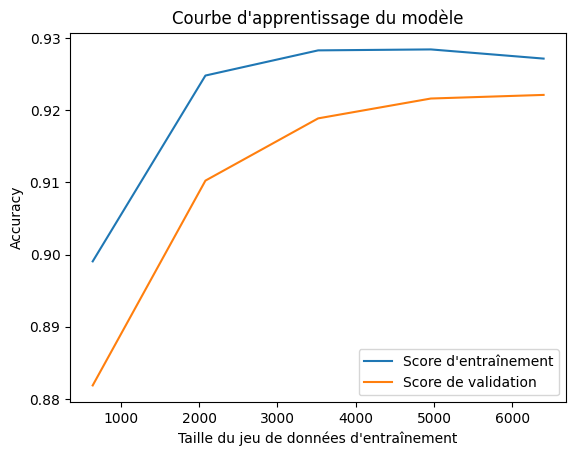

In [426]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, validation_scores = learning_curve(xgb_pipe_opti, X_train, y_train, cv=5)

plt.plot(train_sizes, train_scores.mean(axis=1), label='Score d\'entraînement')
plt.plot(train_sizes, validation_scores.mean(axis=1), label='Score de validation')

plt.title("Courbe d'apprentissage du modèle")
plt.xlabel('Taille du jeu de données d\'entraînement')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

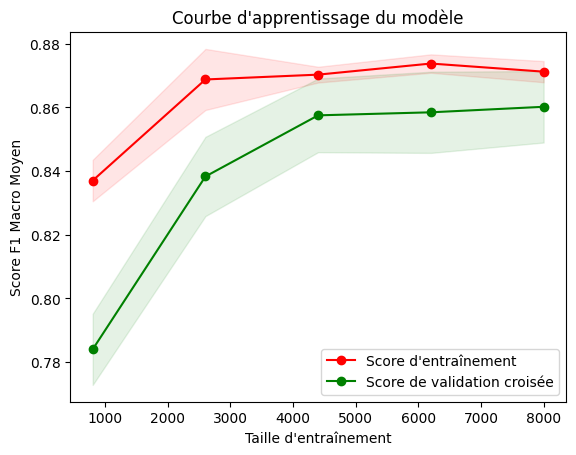

In [427]:
train_sizes, train_scores, test_scores = learning_curve(xgb_pipe_opti, X, y, cv=5, scoring='f1_macro', n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)

test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Score d'entraînement")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Score de validation croisée")

plt.title("Courbe d'apprentissage du modèle")
plt.xlabel("Taille d'entraînement")
plt.ylabel("Score F1 Macro Moyen")
plt.legend(loc="best")
plt.show()

# PCA

In [428]:
numeric_features = list(X.select_dtypes(include=['int', 'float']).columns)

len(numeric_features)

5

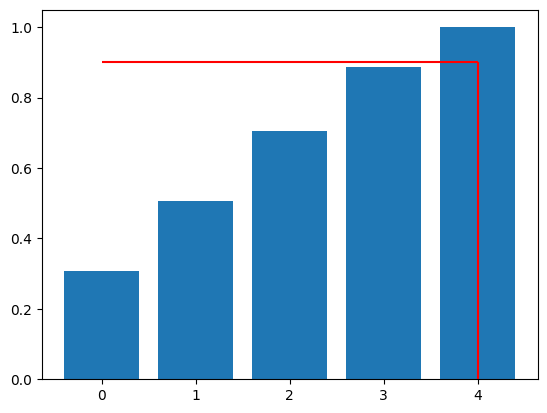

In [429]:
std = StandardScaler()
X_train_standard = std.fit_transform(X_train[numeric_features])

# Choisir le nb de composants
n_dims = X_train_standard.shape[1]
model = PCA(n_components=n_dims)
model.fit(X_train_standard)

variances = model.explained_variance_ratio_

meilleur_dims = np.argmax(np.cumsum(variances) > 0.90)

plt.bar(range(n_dims), np.cumsum(variances))
plt.hlines(0.90, 0, meilleur_dims, colors='r')
plt.vlines(meilleur_dims, 0, 0.90, colors='r')

In [430]:
pca = PCA(n_components=n_dims)

xgb_pipe_opti_pca = make_pipeline(preprocessor, pca, xgb.XGBClassifier())

xgb_pipe_opti_pca.fit(X_train, y_train)
y_pred = xgb_pipe_opti_pca.predict(X_test)

xgb_pipe_opti_report_pca = classification_report(y_test, y_pred)
print(xgb_pipe_opti_report_pca)
print(xgb_opti_report)

              precision    recall  f1-score   support

           0       0.72      0.58      0.64       354
           1       0.91      0.95      0.93      1646

    accuracy                           0.89      2000
   macro avg       0.82      0.77      0.79      2000
weighted avg       0.88      0.89      0.88      2000

              precision    recall  f1-score   support

           0       0.85      0.69      0.76       354
           1       0.94      0.97      0.96      1646

    accuracy                           0.92      2000
   macro avg       0.90      0.83      0.86      2000
weighted avg       0.92      0.92      0.92      2000



In [440]:
model = xgb_pipe_opti_pca.fit(X_train, y_train)

eval_data = X_test.copy()
eval_data["target"] = y_test

with mlflow.start_run():
    pca = PCA(n_dims)
    
    model_info = mlflow.sklearn.log_model(model, "model")
    result = mlflow.evaluate(
        model_info.model_uri,
        eval_data,
        targets="target",
        model_type="classifier",
        evaluators=["default"],
        )

2023/02/06 11:29:08 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2023/02/06 11:29:08 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.
2023/02/06 11:29:10 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Exact is used.
Exact explainer: 2001it [00:40, 39.30it/s]                          
Unable to serialize underlying model using MLflow, will use SHAP serialization
2023/02/06 11:29:53 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpgabq1130/model, flavor: shap), fall back to return ['shap==0.41.0']. Set logging level to DEBUG to see the full traceback.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [441]:
model = xgb_pipe_opti.fit(X_train, y_train)

eval_data = X_test.copy()
eval_data["target"] = y_test

with mlflow.start_run():
    model_info = mlflow.sklearn.log_model(model, "model")
    result = mlflow.evaluate(
        model_info.model_uri,
        eval_data,
        targets="target",
        model_type="classifier",
        evaluators=["default"],
        )

2023/02/06 11:33:07 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2023/02/06 11:33:07 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.
2023/02/06 11:33:09 INFO mlflow.models.evaluation.default_evaluator: Shap explainer Exact is used.
Exact explainer: 2001it [00:33, 42.61it/s]                          
Unable to serialize underlying model using MLflow, will use SHAP serialization
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
